This Notebook, is for the development of a window forecasting model.

## Iteration 1
Following Are some Conditions and Assumption made:

- **NAN Values are not handled**. They are dropped for traininng and predictions
- A **constant window of 3 days** is used for prediction
- **Failure Data Points are not used** for training and Predictions
    - One of the reasons being, we want to see the trends pointing towards the failures and not the actual failures
    - Many a time, when failures occur a well is shutdown and no values are present. Dropping them will help us avoid worrying about imputing the data
    - At first glance this may not impact the algo
    - Further Discussion is needed
- Multi-Class Classification is performed (Not MultiLabel)
- Training is done only on wells where failure occured
- Predictions also done only on those wells (Can easily be done for all wells)

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from library import lib_aws, lib_cleaning
from library.lib_metrics import MultiClassMetrics

## Importing Labeled Data

Labeled data is stored in the database `oasis-dev` in the table `clean.xspoc`

In [14]:
# Setuo the query
failure_wells = ['Cade 12-19HA', 'Cook 12-13 6B', 'Helling Trust 43-22 16T3',
                'Helling Trust 44-22 5B', 'Johnsrud 5198 14-18 13T',
                'Johnsrud 5198 14-18 15TX', 'Rolfson N 5198 12-17 5T',
                'Rolfson N 5198 12-17 7T', 'Rolfson S 5198 11-29 2TX',
                'Rolfson S 5198 11-29 4T', 'Rolfson S 5198 12-29 8T',
                'Rolfson S 5198 14-29 11T', 'Stenehjem 14X-9HA']

query = """
SELECT 
    "NodeID",
    "Date",
    "cardPPRL",
    "cardMPRL",
    "PPRL",
    "MPRL",
    "FluidLoadonPump",
    "PumpIntakePressure",
    "FailureBin",
    "FailureLabel"
FROM
    clean.xspoc
WHERE
    "NodeID" in {}
ORDER BY
    "NodeID", "Date";
""".format(tuple(failure_wells))

In [15]:
%%time
with lib_aws.PostgresRDS(db='oasis-dev') as engine:
    data = pd.read_sql(query, engine, parse_dates=['Date'])
    
data.head()

Connected to oasis-dev DataBase
Connection Closed
Wall time: 10.7 s


,NodeID,Date,cardPPRL,cardMPRL,PPRL,MPRL,FluidLoadonPump,PumpIntakePressure,FailureBin,FailureLabel
0,Cade 12-19HA,2019-03-18 23:30:17,31866.0,17965.0,NaN,NaN,NaN,NaN,0,Normal
1,Cade 12-19HA,2019-03-19 01:20:15,31856.0,17912.0,NaN,NaN,NaN,NaN,0,Normal
2,Cade 12-19HA,2019-03-19 03:36:10,33541.0,17671.0,NaN,NaN,NaN,NaN,0,Normal
3,Cade 12-19HA,2019-03-19 05:20:39,31941.0,18481.0,NaN,NaN,NaN,NaN,0,Normal
4,Cade 12-19HA,2019-03-19 07:21:31,31518.0,18360.0,NaN,NaN,NaN,NaN,0,Normal


In [89]:
"""
Generate Windows
"""

def window_func(df, window):
    """
    Generate MultiLabel windows
    0 = Does not fail
    'Label' = Actual Failure or Fails in the next n window
    :param df: DataFrame with a single well, the Timestamp col should be the index
    :param window: Window Value
    """
    
    df['WinLabel'] = 'Normal'  # Initialize it with 0
    
    mask_ = df.index >= (df.index.max() - pd.Timedelta(window))  
    df.loc[mask_, 'WinLabel'] = -1  # Will eliminate the final window fn
    
    # Iterate over all the labels
    for code in df.loc[df.FailureBin == 1, 'FailureLabel'].unique():
        
         # dates where that code occurs
        code_dates = df[df.FailureLabel == code].index
        # print(code)

        # counter
        c = 0

        # iterate over these dates
        for t in code_dates:
            if c == 0:
                bool_ = (df.index < code_dates[c]) & (df.index >= (code_dates[c] - pd.Timedelta(window)))
                df.loc[bool_, 'WinLabel'] = code
            else:
                bool_ = (df.index < code_dates[c]) & (df.index >= (code_dates[c] - pd.Timedelta(window))) & (
                        df.index > code_dates[c - 1])
                df.loc[bool_, 'WinLabel'] = code
            c = c + 1

        df.loc[df.FailureLabel == code, 'WinLabel'] = code
    
    return df


"""
Function for Moving AVGs
"""

def get_ma(df, cols, freq):
    """
    Rolling Values
    :param df: DataFrame
    :param cols: Columns which are being Rolled
    :param freq: Rolling Window( example: 7D)
    :return: DataFrame with Rolled Values
    """
    for i in cols:
        col_name_1 = i + '_MA'
        df[col_name_1] = df[i].rolling(freq).mean()
    return df


In [185]:
rol_cols = [
    "cardPPRL",
    "cardMPRL",
    "PPRL",
    "MPRL",
    "FluidLoadonPump",
    "PumpIntakePressure"
]
frames = []

for well in data.NodeID.unique():
    print("Well: {}".format(well))
    
    tempdf = data[data.NodeID == well]
    tempdf.set_index("Date", inplace=True)
    
    tempdf = window_func(tempdf, '3 days')
    tempdf = get_ma(tempdf, rol_cols, '7D')
    tempdf.reset_index(inplace=True)
    frames.append(tempdf)

Well: Cade 12-19HA
Well: Cook 12-13 6B
Well: Helling Trust 43-22 16T3


c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

Well: Helling Trust 44-22 5B
Well: Johnsrud 5198 14-18 13T
Well: Johnsrud 5198 14-18 15TX
Well: Rolfson N 5198 12-17 5T
Well: Rolfson N 5198 12-17 7T
Well: Rolfson S 5198 11-29 2TX
Well: Rolfson S 5198 11-29 4T
Well: Rolfson S 5198 12-29 8T
Well: Rolfson S 5198 14-29 11T
Well: Stenehjem 14X-9HA


In [91]:
train_data = pd.concat(frames)  # creeating a train df
train_data = train_data[train_data.WinLabel != -1]
train_data.sort_values(by=['NodeID', 'Date'], inplace=True)

print("Null Value Distribution")
display(train_data.isnull().sum(axis=0))

print("Wells")
display(train_data.NodeID.value_counts())

print("Labels")
display(train_data.WinLabel.value_counts())

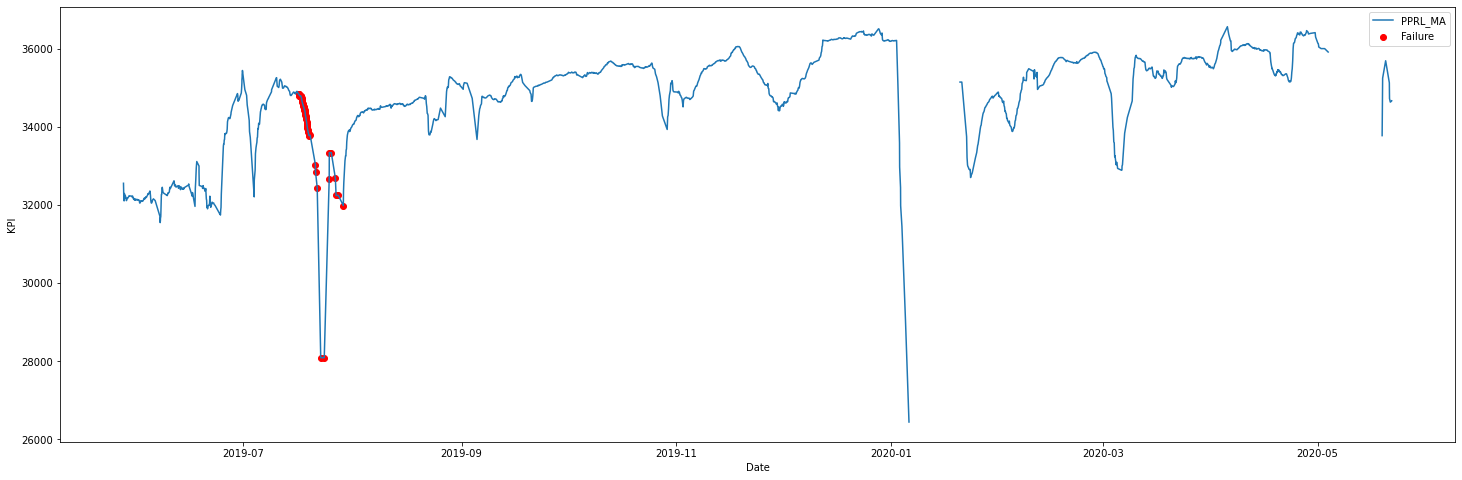

In [186]:
"""
Plotting
"""
col = 'PPRL_MA'
well = 'Helling Trust 43-22 16T3'

well_df = train_data[train_data.NodeID == well]
# well_df.loc[well_df.FailureBin == 1, [col, 'WinLabel']] = np.nan  # Nan where Failures are present
fig, ax = plt.subplots(figsize=(25,8))

ax.plot(well_df.Date, well_df[col], label=col)
bool_ = (well_df.WinLabel != 'Normal')

ax.scatter(well_df.loc[bool_, "Date"], well_df.loc[bool_, col], c='r', label='Failure')

ax.set_xlabel("Date")
ax.set_ylabel("KPI")
ax.legend(loc='best')
plt.show()

In [187]:
# # Droping Failure Data Point
# train_data[train_data.FailureBin == 1]

feature_cols = ['PPRL_MA', 'MPRL_MA', 'FluidLoadonPump_MA', 'PumpIntakePressure_MA']
add_cols=feature_cols + ['NodeID', 'Date', 'WinLabel']
final_train = train_data[add_cols].dropna()
final_train.reset_index(drop=True, inplace=True)

# Features
X = final_train[feature_cols]
Y = final_train.WinLabel

print("Feature df")
display(X.head())

print("Labels Being Predicted")
display(Y.value_counts())

### Algo Test

In [167]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

In [173]:
"""
Model 1
Random Forest classifier
"""

def build_rfc_model():
    """
    Define A Random Forrest Classifier Model
    :return: RFC Model
    """
    scaler = StandardScaler()

    rfc_params = {
        'n_estimators': 100,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'class_weight': 'balanced',
        'verbose': 0,
        'max_features': 'auto',
        'max_depth': None,
    }

    rfc = RandomForestClassifier(**rfc_params)

    model = Pipeline([
        ('scaler', scaler),
        ('rfc', rfc)
    ])

    return model

In [189]:
rfc_model = build_rfc_model()
rfc_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc', RandomForestClassifier(class_weight='balanced'))])

In [190]:
MultiClassMetrics.baseline_metrics(X, Y, rfc_model)

cv_rfc = MultiClassMetrics.cv_validation(X, Y, rfc_model)
print("CV Metrics")
display(cv_rfc)

kf_rfc = MultiClassMetrics.kfold_validation(X, Y, rfc_model)
print("Kfold Metrics")
display(kf_rfc)

Weighted Metrics
Precision : 98.94
Recall: 99.00
F-score: 98.88

Macro Metrics
Precision : 88.62
Recall: 61.95
F-score: 71.23

Classification Report
                  precision    recall  f1-score   support

          Normal       0.99      1.00      0.99     10960
POLISH ROD BREAK       0.87      0.59      0.70        34
    PUMP FAILURE       0.75      0.30      0.43        10
     TUBING LEAK       0.93      0.59      0.72       193

        accuracy                           0.99     11197
       macro avg       0.89      0.62      0.71     11197
    weighted avg       0.99      0.99      0.99     11197



c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV Metrics


,F-Score_wt,Precision_wt,Recall_wt,F-Score_macro,Precision_macro,Recall_macro
0,91.420000,97.420000,86.580000,32.080000,45.930000,27.620000
1,78.260000,95.440000,66.660000,20.580000,24.690000,22.620000
2,97.110000,97.590000,97.520000,31.260000,46.830000,28.700000
Mean,88.930000,96.816667,83.586667,27.973333,39.150000,26.313333
STD,7.894331,0.975921,12.775104,5.238583,10.231364,2.648538


c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Kfold Metrics


,Precision_wt,Recall_wt,F-score_wt,Precision_macro,Recall_macro,F-score_macro
0,98.779999,98.959999,98.820000,63.239998,50.059998,55.159996
1,98.900002,98.949997,98.860001,90.160004,61.809998,67.909996
2,99.159996,99.199997,99.129997,90.800003,76.590004,82.720001
3,98.989998,99.040001,98.919998,94.959999,58.579998,67.669998
4,99.239998,99.250000,99.169998,99.000000,65.620003,75.840004
Mean,99.013998,99.079999,98.979999,87.632001,62.532000,69.859999
STD,0.167761,0.123451,0.142968,12.604188,8.704639,9.228530


In [191]:
"""
Model 2
Gradient Boosted Classifier with Oversampling
"""

def build_gbc_model(y):
    # Building Smote dict
    max_count = int(y.value_counts()[0] / 3)
    class_list = list(y.value_counts().index)
    class_list.remove('Normal')
    smote_dict = {key: max_count for key in class_list}
    print(smote_dict)

    # Define the model pipeline
    scaler = StandardScaler()
    smote = SMOTE(sampling_strategy=smote_dict, random_state=42)
    baseline_param = {
        'n_estimators': 4,
        'max_depth': 8,
        'learning_rate': 0.1,
        'loss': 'deviance',
        'min_samples_split': 2,
        'verbose': 0
    }

    gbc = GradientBoostingClassifier(**baseline_param)

    model = Pipeline([
        ('scaler', scaler),
        ('smote', smote),
        ('gbc', gbc)
    ])

    return model


In [192]:
gbc_model = build_gbc_model(Y)
gbc_model

{'TUBING LEAK': 12177, 'POLISH ROD BREAK': 12177, 'PUMP FAILURE': 12177}


Pipeline(steps=[('scaler', StandardScaler()),
                ('smote',
                 SMOTE(random_state=42,
                       sampling_strategy={'POLISH ROD BREAK': 12177,
                                          'PUMP FAILURE': 12177,
                                          'TUBING LEAK': 12177})),
                ('gbc',
                 GradientBoostingClassifier(max_depth=8, n_estimators=4))])

In [193]:
MultiClassMetrics.baseline_metrics(X, Y, gbc_model)

cv_rfc = MultiClassMetrics.cv_validation(X, Y, gbc_model)
print("CV Metrics")
display(cv_rfc)

kf_rfc = MultiClassMetrics.kfold_validation(X, Y, gbc_model)
print("Kfold Metrics")
display(kf_rfc)

Weighted Metrics
Precision : 98.36
Recall: 97.55
F-score: 97.90

Macro Metrics
Precision : 52.02
Recall: 76.17
F-score: 58.50

Classification Report
                  precision    recall  f1-score   support

          Normal       0.99      0.98      0.99     10960
POLISH ROD BREAK       0.46      0.74      0.57        34
    PUMP FAILURE       0.10      0.60      0.18        10
     TUBING LEAK       0.52      0.73      0.61       193

        accuracy                           0.98     11197
       macro avg       0.52      0.76      0.58     11197
    weighted avg       0.98      0.98      0.98     11197



c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV Metrics


,F-Score_wt,Precision_wt,Recall_wt,F-Score_macro,Precision_macro,Recall_macro
0,80.580000,96.500000,69.330000,28.360000,35.490000,35.590000
1,73.390000,95.300000,60.060000,19.300000,24.630000,21.390000
2,93.160000,95.960000,90.530000,24.830000,25.310000,24.610000
Mean,82.376667,95.920000,73.306667,24.163333,28.476667,27.196667
STD,8.170444,0.490714,12.753186,3.728649,4.966940,6.078823


Kfold Metrics


,Precision_wt,Recall_wt,F-score_wt,Precision_macro,Recall_macro,F-score_macro
0,98.430000,98.110001,98.239998,60.189999,81.070000,67.599998
1,98.220001,98.019997,98.079994,55.800003,73.409996,60.670002
2,98.389999,98.019997,98.169998,54.910000,76.990005,61.009998
3,98.299995,98.189995,98.229996,65.290001,80.760002,71.250000
4,98.290001,97.919998,98.079994,56.449997,77.200005,63.290001
Mean,98.325999,98.051997,98.159996,58.528000,77.886002,64.764000
STD,0.074993,0.091520,0.069571,3.829801,2.818005,4.077673


## Making Predictions on the entire dataset

- Task Done for showing quick results in the dashboard
- All wells used in the training set.
- These same values are used in predictions as well
- Visually when ploted the results will be, how we expect our results to look
- Take the predictions with a big grain of salt


### Prediciton Table

The Results are added to a prediciton table in the 'oasis-dev' database.

Following Columns will be present in the `clean.win_predictons` table:
- NodeID
- Date
- FailureProb
- Prob1 
- Prob2
- Prob3

WIll use a basic rfc model and for features we use the following 7-day Moving Averages
- PPRL_MA
- MPRL_MA
- FluidloadonPump_MA
- PumpIntakePressure_MA

This combination gave the best results in the tests.

In [197]:
# import the entire dataset with the columns we need for making predictions and the failrue info

query = """
SELECT
    "NodeID",
    "Date",
    "PPRL",
    "MPRL",
    "FluidLoadonPump",
    "PumpIntakePressure",
    "FailureBin",
    "FailureLabel"
FROM
    clean.xspoc
ORDER BY
    "NodeID", "Date"
"""

In [198]:
%%time
with lib_aws.PostgresRDS(db='oasis-dev') as engine:
    data = pd.read_sql(query, engine, parse_dates=['Date'])
    
data.head()

Connected to oasis-dev DataBase
Connection Closed
Wall time: 16.7 s


,NodeID,Date,PPRL,MPRL,FluidLoadonPump,PumpIntakePressure,FailureBin,FailureLabel
0,Bonner 9-12H,2019-01-22 13:30:13,NaN,NaN,NaN,NaN,0,Normal
1,Bonner 9-12H,2019-01-23 00:00:00,NaN,NaN,NaN,NaN,0,Normal
2,Bonner 9-12H,2019-01-24 00:00:00,NaN,NaN,NaN,NaN,0,Normal
3,Bonner 9-12H,2019-01-25 00:00:00,NaN,NaN,NaN,NaN,0,Normal
4,Bonner 9-12H,2019-01-26 00:00:00,NaN,NaN,NaN,NaN,0,Normal


In [200]:
# Generating Features
rol_cols = [
    "PPRL",
    "MPRL",
    "FluidLoadonPump",
    "PumpIntakePressure"
]
frames = []

for well in data.NodeID.unique():
    print("Well: {}".format(well))
    
    tempdf = data[data.NodeID == well]
    tempdf.set_index("Date", inplace=True)
    
    tempdf = window_func(tempdf, '3 days')
    tempdf = get_ma(tempdf, rol_cols, '7D')
    tempdf.reset_index(inplace=True)
    frames.append(tempdf)

Well: Bonner 9-12H
Well: Bonner 9X-12HA
Well: Bonner 9X-12HB
Well: Cade 12-19HA


c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Well: Cade 12-19HB
Well: Cade 12X-19H
Well: Cook 12-13 6B
Well: Cook 12-13 7T
Well: Cook 12-13 9T
Well: Cook 41-12 11T
Well: Hanover Federal 5300 41-11 10B
Well: Hanover Federal 5300 41-11 11T
Well: Hanover Federal 5300 41-11 12B
Well: Hanover Federal 5300 41-11 13TX
Well: Helling Trust 43-22 10T
Well: Helling Trust 43-22 16T3
Well: Helling Trust 43-22 4B
Well: Helling Trust 44-22 5B
Well: Helling Trust 44-22 6B
Well: Helling Trust 44-22 7B
Well: Johnsrud 5198 14-18 11T
Well: Johnsrud 5198 14-18 13T
Well: Johnsrud 5198 14-18 15TX
Well: Lite 5393 31-11 9B
Well: Lite 5393 41-11 11B
Well: Lite 5393 41-11 12T
Well: Rolfson N 5198 12-17 5T
Well: Rolfson N 5198 12-17 7T
Well: Rolfson S 5198 11-29 2TX
Well: Rolfson S 5198 11-29 4T
Well: Rolfson S 5198 12-29 6T
Well: Rolfson S 5198 12-29 8T
Well: Rolfson S 5198 14-29 11T
Well: Rolfson S 5198 14-29 13T
Well: Spratley 5494 14-13 12B
Well: Spratley 5494 14-13 13T
Well: Spratley 5494 14-13 15T
Well: Stenehjem 14-9H
Well: Stenehjem 14X-9HA
Well: St

In [201]:
train_data = pd.concat(frames)  # creeating a train df
train_data = train_data[train_data.WinLabel != -1]
train_data.sort_values(by=['NodeID', 'Date'], inplace=True)

print("Null Value Distribution")
display(train_data.isnull().sum(axis=0))

print("Wells")
display(train_data.NodeID.value_counts())

print("Labels")
display(train_data.WinLabel.value_counts())

Null Value Distribution


Date                         0
NodeID                       0
PPRL                     86007
MPRL                     86007
FluidLoadonPump          86007
PumpIntakePressure       90902
FailureBin                   0
FailureLabel                 0
WinLabel                     0
PPRL_MA                  84693
MPRL_MA                  84693
FluidLoadonPump_MA       84693
PumpIntakePressure_MA    84820
dtype: int64

Wells


Lite 5393 31-11 9B                 21227
Hanover Federal 5300 41-11 13TX    20342
Stenehjem 14X-9HA                  10793
Stenehjem 15-9HB                    6382
Stenehjem 15-9HA                    5206
Helling Trust 43-22 4B              5045
Stenehjem 14-9H                     4924
Johnsrud 5198 14-18 13T             4678
Rolfson S 5198 14-29 11T            4559
Cade 12-19HA                        4025
Bonner 9X-12HB                      4007
Helling Trust 44-22 5B              3884
Stenehjem 14X-9HB                   3786
Cook 12-13 6B                       3651
Johnsrud 5198 14-18 15TX            3642
Johnsrud 5198 14-18 11T             3605
Stenehjem 15X-9H                    3536
Cade 12X-19H                        3390
Rolfson S 5198 12-29 6T             3369
Cade 12-19HB                        3342
Rolfson S 5198 11-29 2TX            3209
Rolfson S 5198 11-29 4T             3190
Rolfson N 5198 12-17 5T             3138
Bonner 9X-12HA                      3131
Helling Trust 44

Labels


Normal              175697
TUBING LEAK            828
POLISH ROD BREAK       135
PUMP FAILURE            50
Name: WinLabel, dtype: int64

In [202]:
# # Droping Failure Data Point
# train_data[train_data.FailureBin == 1]

feature_cols = ['PPRL_MA', 'MPRL_MA', 'FluidLoadonPump_MA', 'PumpIntakePressure_MA']
add_cols=feature_cols + ['NodeID', 'Date', 'WinLabel']
final_train = train_data[add_cols].dropna()
final_train.reset_index(drop=True, inplace=True)

# Features
X = final_train[feature_cols]
Y = final_train.WinLabel

print("Feature df")
display(X.head())

print("Labels Being Predicted")
display(Y.value_counts())

Feature df


,PPRL_MA,MPRL_MA,FluidLoadonPump_MA,PumpIntakePressure_MA
0,33965.000000,17623.000000,8822.000000,880.000000
1,33965.000000,17623.000000,8822.000000,880.000000
2,33965.000000,17623.000000,8822.000000,880.000000
3,32935.000000,18105.500000,9358.500000,659.000000
4,32516.666667,18468.333333,8817.333333,883.666667


Labels Being Predicted


Normal              91009
TUBING LEAK           719
POLISH ROD BREAK      126
PUMP FAILURE           36
Name: WinLabel, dtype: int64

In [204]:
# quick test
rfc_model = build_rfc_model()
display(rfc_model)

MultiClassMetrics.baseline_metrics(X, Y, rfc_model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc', RandomForestClassifier(class_weight='balanced'))])

Weighted Metrics
Precision : 99.58
Recall: 99.60
F-score: 99.55

Macro Metrics
Precision : 97.75
Recall: 60.00
F-score: 67.97

Classification Report
                  precision    recall  f1-score   support

          Normal       1.00      1.00      1.00     27302
POLISH ROD BREAK       0.96      0.68      0.80        38
    PUMP FAILURE       1.00      0.09      0.17        11
     TUBING LEAK       0.95      0.62      0.75       216

        accuracy                           1.00     27567
       macro avg       0.98      0.60      0.68     27567
    weighted avg       1.00      1.00      1.00     27567



In [205]:
# Fit the whole df 
rfc_model = build_rfc_model()
rfc_model.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc', RandomForestClassifier(class_weight='balanced'))])

In [209]:
"""
Predictions
"""
print("Classes Predicted {}".format(rfc_model.classes_))
y_hat = rfc_model.predict(X.to_numpy())                                          # Get predictions
y_prob = rfc_model.predict_proba(X.to_numpy()) 

Classes Predicted ['Normal' 'POLISH ROD BREAK' 'PUMP FAILURE' 'TUBING LEAK']


In [214]:
ind = final_train.index
data_pred = final_train[["NodeID", "Date"]]
data_pred.loc[ind, 'PredClass'] = y_hat 

pred_classes = rfc_model.classes_

for i in range(np.shape(pred_classes)[0]):
    print(i)
    col = 'Prob ' + str(pred_classes[i])
    data_pred.loc[ind, col] = y_prob[:, i] * 100
data_pred = data_pred.round(3)
data_pred['FailureProb'] = 100 - data_pred['Prob Normal']
data_pred.drop(columns='Prob Normal', inplace=True)

0
1
2
3


c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [216]:
data_pred.head()

,NodeID,Date,PredClass,Prob POLISH ROD BREAK,Prob PUMP FAILURE,Prob TUBING LEAK,FailureProb
0,Bonner 9-12H,2019-07-12 12:20:58,Normal,0.0,0.0,0.0,0.0
1,Bonner 9-12H,2019-07-12 12:25:28,Normal,0.0,0.0,0.0,0.0
2,Bonner 9-12H,2019-07-13 00:00:00,Normal,0.0,0.0,0.0,0.0
3,Bonner 9-12H,2019-07-14 09:06:04,Normal,0.0,0.0,0.0,0.0
4,Bonner 9-12H,2019-07-14 10:59:27,Normal,0.0,0.0,0.0,0.0


In [218]:
"""
Adding Prob data to DF
"""

# Replace the full bounds df
lib_aws.AddData.add_data(df=data_pred, db='oasis-dev', table='xpred', schema='clean',
                         merge_type='replace', card_col=None, index_col='Date')

# Update index on pred table in database
with lib_aws.PostgresRDS(db='oasis-dev') as engine:
    with engine.begin() as connection:
        connection.execute("""CREATE UNIQUE INDEX xpred_idx ON clean.xpred ("NodeID", "Date");""")


Connected to oasis-dev DataBase
Connection Closed
